In [1]:
!pip install datasets[vision] tensorflow opencv-python-headless matplotlib scikit-learn

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for datasets[vision] from https://files.pythonhosted.org/packages/09/7e/fd4d6441a541dba61d0acb3c1fd5df53214c2e9033854e837a99dd9e0793/datasets-2.14.5-py3-none-any.whl.metadata
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/e2/7a/c7762c698fb1ac41a7e3afee51dc72aa3ec74ae8d2f57ce19a9cded3a4af/tensorflow-2.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for opencv-python-headless from https://files.pythonhosted.org/packages/9d/d7/e2aaf344254292d2046f9984b54212e4e7d69a57d30ae15e7294840710f6/opencv_python_headless-4.8.1.78-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/b5/24/aaccf324ce862bb82277e8814d2aebbb2a2c160d04e95aa2b8c9dc3137a9/matplotlib-3.8.0-cp310-cp310-m

In [2]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install opencv-python-headless

Defaulting to user installation because normal site-packages is not writeable


In [4]:
#import cv2
import datasets
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from sklearn.metrics import mean_squared_error

# custom models
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer, Conv2DTranspose, Activation
from tensorflow.keras.models import Sequential, Model

# vgg16
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

/home/ucloud/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-28 13:41:38.317499: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-28 13:41:38.360811: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-09-28 13:41:38.360834: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-09-28 13:41:38.360862: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one 

In [8]:
###
### data
###

wikiart = datasets.load_dataset("huggan/wikiart", split='train', streaming=True).take(2200)

def gen_from_iterable_dataset(iterable_ds):
    yield from iterable_ds

ds = datasets.Dataset.from_generator(partial(gen_from_iterable_dataset, wikiart), features=wikiart.features)

Resolving data files: 100%|██████████| 72/72 [00:26<00:00,  2.67it/s]
Generating train split: 2200 examples [01:07, 32.64 examples/s]


In [5]:
# the dataset can be saved locally
#ds.save_to_disk("wikiart_2200")
ds = datasets.load_from_disk("wikiart_2200")

In [6]:
###
### preprocess
###

def _preprocess_image_std(example):
  # resize to VGG input size
  X = example['image']
  X = X.resize((224, 224))
  X = image.img_to_array(X)
  X = np.expand_dims(X, axis=0)
  X = X.astype('float32') / 255.0
  example['image'] = X
  return example

def _preprocess_image(example):
  # resize to VGG input size
  X = example['image']
  X = X.resize((224, 224))
  X = image.img_to_array(X)
  X = np.expand_dims(X, axis=0)
  X = preprocess_input(X)
  example['image'] = X
  return example


ds_small = (ds
      .select(list(range(1000)))
      .map(_preprocess_image)
)

#ds_small_std = (ds
      #.select(list(range(1000)))
      #.map(_preprocess_image_std)
#)

ds_small_tf = ds_small.to_tf_dataset(
            columns=["image"],
            # label_cols=["image"],
            )

#ds_small_std_tf = ds_small_std.to_tf_dataset(
          #  columns=["image"],
            # label_cols=["image"],
          #  )

original_images = ds_small.with_format('np', columns=['image'], output_all_columns=False)['image']
original_image = np.array(ds_small[0]['image'])

#original_images_std = ds_small_std.with_format('np', columns=['image'], output_all_columns=False)['image']
#original_image_std = np.array(ds_small_std[0]['image'])

Map: 100%|██████████| 1000/1000 [05:54<00:00,  2.82 examples/s]
/home/ucloud/.local/lib/python3.10/site-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [7]:
###
### encoder VGG16
###

# Load the VGG16 model with pre-trained weights (excluding the top classification layers)
vgg16 = VGG16(weights='imagenet', include_top=False)

# Encode the image using the VGG16 model
encoded_features = vgg16.predict(original_image)
encoded_dataset = vgg16.predict(ds_small_tf)

# Print the shape of the encoded features
print("Shape of encoded features:", encoded_features.shape)
print("Shape of encoded dataset:", encoded_dataset.shape)


1000/1000 [==============================] - 315s 315ms/step
Shape of encoded features: (1, 7, 7, 512)
Shape of encoded dataset: (1000, 7, 7, 512)


In [14]:
encoded_features_std = vgg16.predict(original_image_std)
encoded_dataset_std = vgg16.predict(ds_small_std_tf)

1000/1000 [==============================] - 323s 323ms/step


In [15]:
###
### decoder VGG16
###

# Define the input for the decoder
encoded_input = Input(shape=(7, 7, 512))  # Shape matches the output shape of VGG16's encoder

# Add transpose convolutional layers to upsample the encoded features
x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(encoded_input)
x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
x = Conv2DTranspose(3, (3, 3), strides=(4, 4), padding='same', activation='sigmoid')(x)  # Output layer, using sigmoid activation for pixel values

# Create the decoder model
decoder = Model(inputs=encoded_input, outputs=x)

# Print a summary of the decoder model
decoder.summary()

# yeah
decoder.compile(loss='mean_squared_error', optimizer='adam')
decoder.fit(encoded_dataset, original_images, epochs=10)

# Reconstruct the original image
reconstructed_image = decoder.predict(encoded_features)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 7, 7, 512)]       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 256)       1179904   
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 128)       295040    
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 56, 56, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 224, 224, 3)       1731      
 Transpose)                                                  

In [16]:
decoder.fit(encoded_dataset_std, original_images_std, epochs=10)

# Reconstruct the original image
reconstructed_image_std = decoder.predict(encoded_features_std)

Epoch 1/10
32/32 [==============================] - 20s 603ms/step - loss: 0.2036
Epoch 2/10
32/32 [==============================] - 19s 588ms/step - loss: 0.2034
Epoch 3/10
32/32 [==============================] - 19s 601ms/step - loss: 0.2031
Epoch 4/10
32/32 [==============================] - 19s 597ms/step - loss: 0.2021
Epoch 5/10
32/32 [==============================] - 19s 597ms/step - loss: 0.1978
Epoch 6/10
32/32 [==============================] - 19s 591ms/step - loss: 0.1831
Epoch 7/10
32/32 [==============================] - 19s 590ms/step - loss: 0.1143
Epoch 8/10
32/32 [==============================] - 19s 601ms/step - loss: 0.0703
Epoch 9/10
32/32 [==============================] - 19s 593ms/step - loss: 0.0702
Epoch 10/10
1/1 [==============================] - 0s 31ms/step


In [17]:
###
### errror
###

original_image_flat = original_image.flatten()
reconstructed_image_flat = reconstructed_image.flatten()

# Calculate the Mean Squared Error
mse = mean_squared_error(original_image_flat, reconstructed_image_flat)

# Print the MSE
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 3255.9276315162774


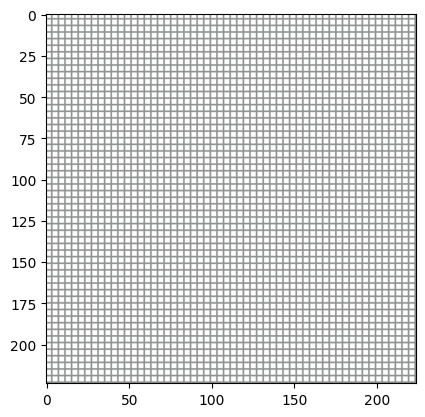

In [18]:
plt.imshow(np.squeeze(reconstructed_image, axis=0))

In [99]:
plt.imshow(np.squeeze(reconstructed_image_std*255, axis=0))

NameError: name 'reconstructed_image_std' is not defined

In [37]:
np.amax(reconstructed_image_std)

0.5702454

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


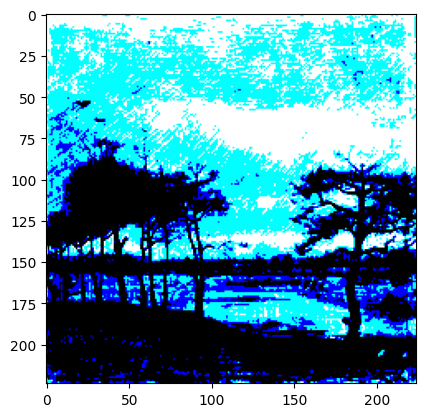

In [26]:
plt.imshow(np.squeeze(original_image, axis=0))

### exact architecture of vgg16

In [30]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [8]:
from keras.layers import UpSampling2D, Conv2D, ZeroPadding2D

In [10]:
encoded_input = Input(shape=(7, 7, 512))  # Shape matches the output shape of VGG16's encoder
upsp1 = UpSampling2D(size = (2,2), name = 'upsp1')(encoded_input)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', name = 'conv6_1')(upsp1)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', name = 'conv6_2')(conv6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', name = 'conv6_3')(conv6)

upsp2 = UpSampling2D(size = (2,2), name = 'upsp2')(conv6)
conv7 = Conv2D(512, 3, activation = 'relu', padding = 'same', name = 'conv7_1')(upsp2)
conv7 = Conv2D(512, 3, activation = 'relu', padding = 'same', name = 'conv7_2')(conv7)
conv7 = Conv2D(512, 3, activation = 'relu', padding = 'same', name = 'conv7_3')(conv7)
#zero1 = ZeroPadding2D(padding =  ((1, 0), (1, 0)), data_format = 'channels_last', name='zero1')(conv7)

upsp3 = UpSampling2D(size = (2,2), name = 'upsp3')(conv7)
conv8 = Conv2D(256, 3, activation = 'relu', padding = 'same', name = 'conv8_1')(upsp3)
conv8 = Conv2D(256, 3, activation = 'relu', padding = 'same', name = 'conv8_2')(conv8)
conv8 = Conv2D(256, 3, activation = 'relu', padding = 'same', name = 'conv8_3')(conv8)

upsp4 = UpSampling2D(size = (2,2), name = 'upsp4')(conv8)
conv9 = Conv2D(128, 3, activation = 'relu', padding = 'same', name = 'conv9_1')(upsp4)
conv9 = Conv2D(128, 3, activation = 'relu', padding = 'same', name = 'conv9_2')(conv9)

upsp5 = UpSampling2D(size = (2,2), name = 'upsp5')(conv9)
conv10 = Conv2D(64, 3, activation = 'relu', padding = 'same', name = 'conv10_1')(upsp5)
conv10 = Conv2D(64, 3, activation = 'relu', padding = 'same', name = 'conv10_2')(conv10)

conv11 = Conv2D(3, 3, activation = 'relu', padding = 'same', name = 'conv11')(conv10)

In [11]:
model = Model(encoded_input, conv11)

In [12]:
# yeah
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(encoded_dataset, original_images, epochs=10)

# Reconstruct the original image
reconstructed_image_new = model.predict(encoded_features)

Epoch 1/10
32/32 [==============================] - 285s 9s/step - loss: 447264.4688
Epoch 2/10
32/32 [==============================] - 284s 9s/step - loss: 4389.6021
Epoch 3/10
32/32 [==============================] - 283s 9s/step - loss: 4423.6279
Epoch 4/10
32/32 [==============================] - 283s 9s/step - loss: 4388.8003
Epoch 5/10
32/32 [==============================] - 283s 9s/step - loss: 4355.5469
Epoch 6/10
32/32 [==============================] - 282s 9s/step - loss: 4315.9697
Epoch 7/10
32/32 [==============================] - 281s 9s/step - loss: 4203.6362
Epoch 8/10
32/32 [==============================] - 281s 9s/step - loss: 4244.1196
Epoch 9/10
32/32 [==============================] - 281s 9s/step - loss: 4208.8462
Epoch 10/10
1/1 [==============================] - 0s 187ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


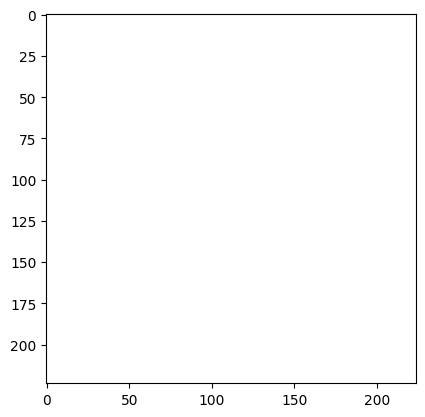

In [13]:
plt.imshow(np.squeeze(reconstructed_image_new, axis=0))

In [81]:
np.amin(original_image)
np.amax(reconstructed_image_new)

-123.68000030517578

In [85]:
np.amax(original_image)

0.9176470637321472

In [14]:
import datasets
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm

import tensorflow as tf
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import (load_img, img_to_array)
from tensorflow.keras.applications.vgg16 import (VGG16, preprocess_input)

In [74]:
def extract_features(img, model):
    """
    Extract features from image data using pretrained model (e.g. VGG16)

    Arguments:
    - img_path: path to image to extract features on
    - model: model to use as a feature extractor

    Returns:
    - A list of image embeddings for the input image

    Source:
        This function is taken from the Session 10 Notebook for the Visual Analytics Course.
    """
    # Define input image shape - remember we need to reshape
    #input_shape = (224, 224, 3)
    # load image from file path
    #img = load_img(img, target_size=(input_shape[0],
                                          #input_shape[1]))
    # convert to array
    #img_array = img_to_array(img)
    # expand to fit dimensions
    expanded_img_array = np.expand_dims(img, axis=0)
    # preprocess image - see last week's notebook
    preprocessed_img = preprocess_input(expanded_img_array)
    # use the predict function to create feature representation
    features = model.predict(expanded_img_array)
    # flatten
    #flattened_features = features.flatten()
    # normalise features
    normalized_features = features / norm(features)

    return normalized_features

In [77]:
test = extract_features(org_images[0], model)
test[0]

1/1 [==============================] - 0s 74ms/step


array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

In [78]:
np.amax(test)

0.21950677

In [60]:
  model = VGG16(weights='imagenet', 
              include_top=False,
              input_shape=(224, 224, 3))

In [72]:
org_images = np.squeeze(original_images, axis=1)

In [79]:
feature_list = []

for i in range(len(org_images)):
    im = org_images[i]
    feature = extract_features(im, model)
    feature_list.append(feature)

features = np.asarray(feature_list)
features.shape

1/1 [==============================] - 0s 70ms/step


(1000, 1, 7, 7, 512)

In [82]:
features_squeezed = np.squeeze(features, axis=1)

In [89]:
features_squeezed.shape

(1000, 7, 7, 512)

In [88]:
# Define the input for the decoder
encoded_input = Input(shape=(7, 7, 512))  # Shape matches the output shape of VGG16's encoder

# Add transpose convolutional layers to upsample the encoded features
x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(encoded_input)
x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
x = Conv2DTranspose(3, (3, 3), strides=(4, 4), padding='same', activation='sigmoid')(x)  # Output layer, using sigmoid activation for pixel values

# Create the decoder model
decoder = Model(inputs=encoded_input, outputs=x)

# Print a summary of the decoder model
decoder.summary()

# yeah
decoder.compile(loss='mean_squared_error', optimizer='adam')

decoder.fit(features_squeezed, original_images, epochs=10)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 7, 7, 512)]       0         
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 14, 14, 256)       1179904   
 Transpose)                                                      
                                                                 
 conv2d_transpose_10 (Conv2  (None, 28, 28, 128)       295040    
 DTranspose)                                                     
                                                                 
 conv2d_transpose_11 (Conv2  (None, 56, 56, 64)        73792     
 DTranspose)                                                     
                                                                 
 conv2d_transpose_12 (Conv2  (None, 224, 224, 3)       1731      
 DTranspose)                                               

ValueError: in user code:

    File "/home/ucloud/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2416, in predict_function  *
        return step_function(self, iterator)
    File "/home/ucloud/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2401, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ucloud/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2389, in run_step  **
        outputs = model.predict_step(data)
    File "/home/ucloud/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2357, in predict_step
        return self(x, training=False)
    File "/home/ucloud/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/ucloud/.local/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_3" is incompatible with the layer: expected shape=(None, 7, 7, 512), found shape=(None, 7, 512)


In [94]:
expanded = np.expand_dims(features_squeezed[0], axis=0)

# Reconstruct the original image
reconstructed_image = decoder.predict(expanded)

1/1 [==============================] - 0s 92ms/step


In [96]:
testy = reconstructed_image*norm(reconstructed_image)

In [98]:
reconstructed_image

array([[[[1.2181696e-03, 5.7093250e-03, 2.3651451e-03],
         [2.7480992e-03, 1.5281070e-03, 3.5187155e-03],
         [8.5848325e-04, 3.3993446e-03, 3.4226812e-03],
         ...,
         [1.0998658e-03, 3.2664562e-04, 1.5852859e-03],
         [2.7885789e-04, 1.3157881e-03, 1.2991936e-03],
         [4.3498740e-01, 4.3524212e-01, 4.3576512e-01]],

        [[7.9977879e-04, 5.8354228e-03, 6.9605187e-04],
         [4.2448449e-03, 2.4370062e-03, 3.8626406e-03],
         [9.5510331e-04, 1.1399026e-03, 4.6759560e-03],
         ...,
         [2.2248654e-03, 7.2575716e-04, 1.6577583e-03],
         [4.3589249e-04, 4.4312023e-04, 3.5122179e-03],
         [4.3498740e-01, 4.3524212e-01, 4.3576512e-01]],

        [[3.2529582e-03, 1.5167928e-03, 8.7443097e-03],
         [2.2629208e-03, 2.5274097e-03, 9.4814319e-03],
         [3.9094474e-04, 2.4058407e-03, 2.3494386e-03],
         ...,
         [1.6611227e-03, 1.1639302e-03, 5.1302714e-03],
         [1.2270665e-04, 9.9714578e-04, 1.5553561e-03],
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


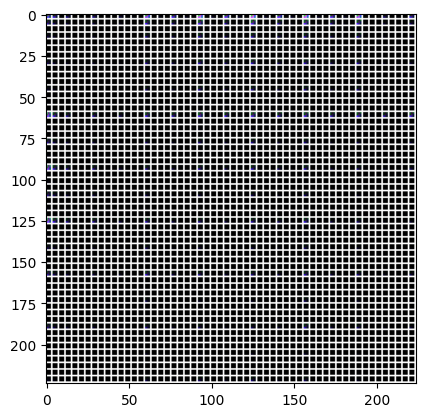

In [97]:
plt.imshow(np.squeeze(testy, axis=0))

In [101]:
reconstructed_image

array([[[[1.2181696e-03, 5.7093250e-03, 2.3651451e-03],
         [2.7480992e-03, 1.5281070e-03, 3.5187155e-03],
         [8.5848325e-04, 3.3993446e-03, 3.4226812e-03],
         ...,
         [1.0998658e-03, 3.2664562e-04, 1.5852859e-03],
         [2.7885789e-04, 1.3157881e-03, 1.2991936e-03],
         [4.3498740e-01, 4.3524212e-01, 4.3576512e-01]],

        [[7.9977879e-04, 5.8354228e-03, 6.9605187e-04],
         [4.2448449e-03, 2.4370062e-03, 3.8626406e-03],
         [9.5510331e-04, 1.1399026e-03, 4.6759560e-03],
         ...,
         [2.2248654e-03, 7.2575716e-04, 1.6577583e-03],
         [4.3589249e-04, 4.4312023e-04, 3.5122179e-03],
         [4.3498740e-01, 4.3524212e-01, 4.3576512e-01]],

        [[3.2529582e-03, 1.5167928e-03, 8.7443097e-03],
         [2.2629208e-03, 2.5274097e-03, 9.4814319e-03],
         [3.9094474e-04, 2.4058407e-03, 2.3494386e-03],
         ...,
         [1.6611227e-03, 1.1639302e-03, 5.1302714e-03],
         [1.2270665e-04, 9.9714578e-04, 1.5553561e-03],
  